## Trackside Acoustic Rail Traffic Classification with Neural Networks and Linear Discriminant Analysis

#### Michael Byrne, michael.byrne@colostate.edu


### Abstract
_Research into acoustic event detection is thus far largely focused on idealized scenarios involving highly differentiated classes. Industry-geared efforts are, meanwhile, almost entirely focused on speech processing. Here we attempt to advance practical acoustic classification into the domain of industrial surveillance, particularly the classification of rail traffic in real-time. With audio data collected over several weeks in Vancouver, WA, we employ feature frequency-domain subsets for classification tasks that are unusually human ear agnostic. Building on limited earlier work in acoustic scene classification, we develop and test both linear logistic regression and neural network models. A low-power embedded device for perorming real-time classification is then described. Results suggest that industrial acoustic surveillance is a currently viable technology that nonetheless remains underutilized._

## 1. Introduction
Virtually every research effort into acoustic classification using machine learning assumes an intermediate human ear. Classifiers are built to simulate its physiology and, crucially, its limitations. Given tasks such as scene classification and speech recognition, this is reasonable. The nature of the classified in these cases is bound by human semantics. But it's trivial to imagine scenarios in which making this assumption is no longer reasonable. Take sounds from the natural world, for example, or industrial soundscapes. In the machine learning context, we can imagine the human ear being a limitation rather than a neccessary interpretive layer. 

Here we consider a scenario in which a human interpreter would almost certainly be unable to make classifications based only on acoustic input. To most anyone, a train sounds like a train. It's loud and noisy. But we know from preliminary spectral analyses and indeed some careful listening on the part of well-trained human ears that marked differences exist in the frequency distributions of train sounds that persist at variable distances and among variable acoustic backgrounds. We hypothesize that different varieties of rail car offer acoustic signatures for the simple reason that rail cars are mechanically distinct in several key ways: aerodynamic profile, weight distribution, loose hardware (e.g. boxcar doors, gondola hatches, walkways, chains, etc), shock absorption, typical cargo weight. 

We hypothesize further that it's possible to craft acoustic models of "normal" car operation. Such models have implications for not just railway operation&mdash;such as improved trackside anomaly detection&mdash;but industrial operations in general. One might imagine an acoustic event detection system replacing or supplanting human visual inspections in dangerous or inaccessible environments, or where frequent human inspections are impractical or expensive. Moreover, by implementing a model of normal operation, it may be possible to \textit{predict} mechanical failures that have so-far been unobserved. This is roughly analogous to machine learning-based anomaly detection currently being studied in computer security[1]. 

Our work was initially motivated by railcar counting efforts in the Pacific-Northwest[2]. Recent incidents involving derailed cars carrying petroleum products have caused a spike in concern within trackside communities. Nonetheless, major railways are resistant to releasing data on rail traffic. This is a source of great contention and has led to informal oil car counting efforts along rail right-of-ways in Washington state and Oregon. These are incomplete and sporadic&mdash;hardly surprising given the relative low frequency of rail traffic even along major corridors and the corresponding time commitment. 

We imagine a small low-power embedded device to automate this task. It will retrieve pre-trained models from the cloud as they are refined and updated and will use those models to perform classifications autonomously. The classifications will then be uploaded back to the cloud. In the ideal case, the Railbox device would need only to have its batteries changed with no other human intervention required. 

In this report, we describe the collection of over 40,000 points of acoustic data corresponding to rail traffic in and around Portland, Oregon. We use a subset of this data to train both logistic regression and neural network models and we explore the parameter space of both approaches. We create models based on features corresponding to both wide Fast Fourier Transform (FFT) bins and extracted spectral constrast features, which are commonly used in music analysis algorithms and in enhancing speech intelligibility in noisy environments. We then describe a prototype system for performing autonomous real-time classification with a low-cost microcontroller and electret microphone. 


## 2. Background

Virtually all acoustic classification research to date has focused on speech processing. Given market enthusiasm, that's to be expected. A smaller subset of the field involves acoustic event detection, wherein discrete phenomena are modeled using specialized machine learning approaches suitable for time series data. Naturally, events have beginnings and endings. They evolve through time where individual data points necessarily encode information about earlier data points. The time series relationships built into acoustic event detection problems make them well-suited for Hidden Markov Models (HMMs). In an HMM, data points correspond to sequential observations wherein a given observation can be considered as the product of the next earliest observation in the sequence. Like this, observations may be chained together such that a joint probability can be calculated for a sequence of observations. 

Examples of acoustic event detection outside of speech processing include classification of urban noises (dogs barking, car horns, etc)[3], whale calls[4], frog calls[5], and bird calls[6]. Much of this work is guided by the ongoing IEEE challenge on Detection and Classification of Acoustic Scenes and Events and its associated datasets and open-source baseline event detection framework.

Nearly every example of acoustic event detection involves time series data. What we consider here, however, is acoustic data that consists of independent observations. The train noise we are interested in evaluating does not change through time, or does not change through time in a meaningful way. This enables us to use more conventional machine learning techniques based on models built from independent data points or data points that can be considered to be independent.

## 3. Data Collection
Trains were recorded using the built-in microphone of an iPhone SE at a distance of 10 to 15 feet. Recording took place over several nights at various points on the platforms of the Vancouver, WA Amtrak station. As it's the confluence of several major rail lines, this corridor sees heavy traffic, averaging two or more trains per hour. Oil cars recorded were either part of mixed-freight consists or unit trains (trains pulling only one variety of car for usually one customer). Intermodal trains are by default unit trains. Train speeds were between 15 and 25 mph. Initial recordings were between 30 and 90 seconds and were chunked into one-second clips using an external Python script.  

## 4. Feature Set 1: Naive FFT
Because we're seeking to classify based on audio features whose interpretation is not neccessarily tied to human hearing, we hypothesize that a naive approach using broad spectral bands as features will yield a suitable predictive model. 

Plotting waveforms from two railcar types reveals little beyond the limited observation that oil cars have a denser signal. 

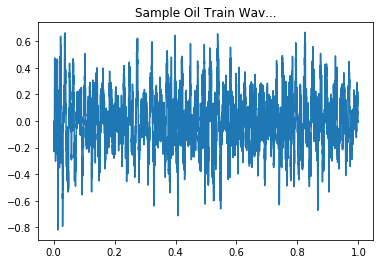

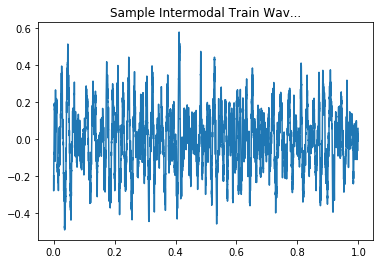

In [1]:
import matplotlib
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


Xoil,sr_oil = librosa.load("samples/oil_test_0.wav")
Time_oil=np.linspace(0, len(Xoil)/sr_oil, num=len(Xoil))
plt.figure(1)
plt.title('Sample Oil Train Wav...')
plt.plot(Time_oil,Xoil)
plt.show()

Xstack,sr_stack = librosa.load("samples/0418a6.wav")
Time_stack=np.linspace(0, len(Xstack)/sr_stack, num=len(Xstack))
plt.figure(1)
plt.title('Sample Intermodal Train Wav...')
plt.plot(Time_stack,Xstack)
plt.show()

And now spectrograms of the same two signals.

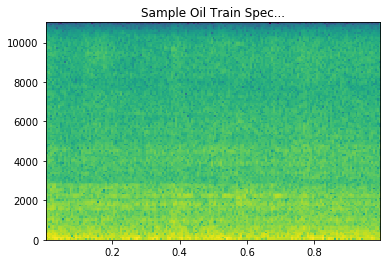

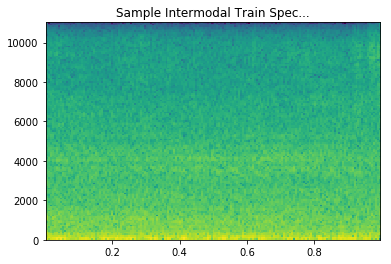

In [2]:
from matplotlib.pyplot import specgram
specgram(np.array(Xoil), Fs=sr_oil)
plt.title('Sample Oil Train Spec...')
plt.show()
plt.title('Sample Intermodal Train Spec...')
specgram(np.array(Xstack), Fs=sr_stack)
plt.show()

The spectrograms aren't dramatically different, but we can see some bands clustered around 2000 Hz. Intuitively, this aligns well with the respective sample waveforms. Later we will reconsider this observation in light of the weights generated during neural network and LDA training.  

To process audio recordings for analysis, we take one second samples (chunked from 1 - 3 minute field recordings using an external Python script) and further subdivide them into 50 ms frames. Using non-time series data allows us to reduce to such small frame sizes because we can consider our samples as indepedent observations; that is, the ordering of our frames is meaningless with respect to the classification task. In classifying discrete acoustic events, such as car horns or animal calls, clearly we would have abide by a lower limit given by the length of the event. Our frame size is somewhat arbitrarily chosen to account for between-car gaps and to ensure a fully "saturated" acoustic profile. 

Below is only an example of the processing involved in a simple audio recording. File names are listed in a subdirectory along with labels corresponding to the type of railcar. Every car type that is not an oil car is converted to class 0, while oil cars are converted to class 1. For simplicity, in our experiments we consider only oil cars and "double-stack" intermodal cars. Of all railcar types, these two varieties have the most dramatic difference in aerodynamic profile, and, anecdotally, they have exceptionally characteristic sounds.  

Because the preprocessing involved is fairly time-intensive, we have included only commented-out example code in the following cell. It takes as input a csv file containing a list of wav files that have been labeled by car type. Every one-minute file is divided into 50 frames. Each frame undergoes a Fast Fourier Transform (FFT) and the resulting frequency-domain data is consolidated into 10 bins per frame. Frequency data for each bin is then normalized and written to file along with the same label that accompanied the original wav file. Data files are then consolidated into one master data file that will later become training data. 

A sampling of data looks like this: 

<blockquote>0.719,0.513,0.376,0.191,0.165,0.102,0.047,0.035,0.027,1  
0.793,0.494,0.268,0.162,0.148,0.079,0.034,0.022,0.016,1  
0.717,0.563,0.327,0.198,0.124,0.073,0.031,0.026,0.012,1  
0.783,0.485,0.305,0.175,0.137,0.081,0.029,0.021,0.013,1  
0.684,0.541,0.398,0.213,0.16,0.09,0.037,0.025,0.014,1  
0.72,0.541,0.313,0.218,0.179,0.086,0.041,0.038,0.014,1  
0.683,0.563,0.37,0.212,0.159,0.081,0.04,0.029,0.01,1  
0.726,0.487,0.352,0.236,0.194,0.126,0.04,0.03,0.015,1  
0.713,0.501,0.404,0.185,0.177,0.094,0.045,0.027,0.014,1
0.807,0.469,0.311,0.124,0.104,0.068,0.045,0.016,0.012,0</blockquote>


In [3]:
# import matplotlib
# matplotlib.use('nbagg')
# import matplotlib.pyplot as plt
# from scipy.fftpack import fft, dct
# import scipy.io.wavfile
# import numpy
# from IPython import display
# import time
# import csv
# %matplotlib inline

### Here we read in file names and labels for audio samples
# with open('samples.csv') as f:
#     samples = []
#     for line in f:
#         sample = line.split()
#         samples.append(sample)

### We open each sample and apply a normalization to emphasize higher frequencies
### We then divide each sample into smaller frames and apply the FFT
### The frequency domain data is then consolidated into 10 bins and normalized from 0 - 1
# for rec in samples:
#     bins = []
#     sample_rate, signal = scipy.io.wavfile.read("samples/" + rec[0])
#     plt.plot(signal)
#     pre_emphasis = 0.97
#     es = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
#     frames = []
#     num_samples = es.size
#     frame_size = num_samples / 50
#     upper =  0
#     lower = 0
#     for i in range(50):
#         lower = i * frame_size
#         upper = lower + frame_size - 1
#         frames.append(es[lower:upper])
#     for frame in frames:
#         c = fft(frame) # calculate fourier transform (complex numbers list)
#         d = len(c)/2  # you only need half of the fft list (real signal symmetry)
#         er = abs(c[:(d-1)])
#         # plt.plot(er,'r') 
#         # plt.show()
#         bins = []
#         bin_size = d / 10
#         for i in range(0,9):
#             lower = i * bin_size
#             bin_total = 0
#             for j in range(lower,lower+bin_size):
#                 bin_total += er[j]
#             bins.append(bin_total)
#         ind=numpy.arange(9)
#         width=0.35
#         bin_arr = numpy.array(bins)
#         plt.bar(ind,bin_arr,width,color="blue")
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         time.sleep(1.0)
        
#         writer = csv.writer(open('data.csv','wb'))
#         writer.writerow([bin_arr])

The final data file ("fft_features_master.txt") consists of 5,441 rows each consisting of 10 features corresponding to the frequency bins resulting from the above preprocessing. Each row ends with a class of either 1 (oil train) or 0 (not oil train).

We rely on machine learning utilities developed for class and-or provided by the instructor. 

In [4]:
!wget http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn2.tar
!mv nn2.tar.1 nn2.tar   # in case I already have a file named nn2.tar in this directory
!tar xvf nn2.tar

--2017-05-09 20:36:53--  http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn2.tar
Resolving www.cs.colostate.edu... 129.82.45.114
Connecting to www.cs.colostate.edu|129.82.45.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51200 (50K) [application/x-tar]
Saving to: ‘nn2.tar.1’

nn2.tar.1           100%[===================>]  50.00K  --.-KB/s    in 0.1s    

2017-05-09 20:36:53 (397 KB/s) - ‘nn2.tar.1’ saved [51200/51200]

x neuralnetworks.py
x mlutils.py
x scaledconjugategradient.py


In [5]:
from types import *
import numpy as np
import scaledconjugategradient as scg
import mlutils as ml  # for draw()
from copy import copy
import sys  # for sys.float_info.epsilon
import pdb
import neuralnetworks as nn
import mpl_toolkits.mplot3d as plt3
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [6]:
prep = np.loadtxt('fft_features_master.txt',delimiter=',')
T = prep[:,9:]
X1 = prep[:,0:9]
nrow,ncol = X1.shape
nrows = X1.shape[0]
nTrain = int(round(nrow*0.8))
nTest = nrow - nTrain
nTrain,nTest,nTrain+nTest

(4353, 1088, 5441)

In [7]:
rows = np.arange(nrows)
np.random.shuffle(rows)

In [8]:
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]
trainIndices,testIndices
Xtrain_fft = X1[trainIndices,:]
Ttrain_fft = T[trainIndices,:]
Xtest_fft = X1[testIndices,:]
Ttest_fft = T[testIndices,:]

With our data ready, we establish some expectations with the most minimal neural network of 1 iteration and 0 hidden layers.  

In [9]:
nHidden = 0
nnet = nn.NeuralNetworkClassifier(9,nHidden,2) # 3 classes, will actually make 2-unit output layer
nnet.train(Xtrain_fft,Ttrain_fft,  nIterations=1, verbose=True)
%precision 3
Ptrain,Prtrain,_ = nnet.use(Xtrain_fft,allOutputs=True)
Ptest,Prtest,_ = nnet.use(Xtest_fft,allOutputs=True)
print('Percent Correct: Training',100*np.sum(Ptrain==Ttrain_fft)/len(Ttrain_fft), 'Testing',100*np.sum(Ptest==Ttest_fft)/len(Ttest_fft))
print()

SCG: Iteration 1 ObjectiveF=0.19876 Scale=1.000e-06 Time=0.00027 s/iter
Percent Correct: Training 88.6744773719 Testing 88.5110294118



A single iteration with no hidden layers is essentially linear logistic regression, so a success rate of nearly 90 percent suggests that we may be able to achieve acceptable classification using a linear logistic regression-derived model. We reuse linear logistic regression functions developed for Assignment 4.

We find that the singular value decomposition fails to converge for our training data. By removing the bias column, we are able to successfully return a model. 

In [10]:
def trainLDA(X, T):
    model = SimpleNamespace()
    model.classes = np.unique(T)
    model.means, model.stds = np.mean(X,0), np.std(X,0)
    Xs = (X - model.means) / model.stds
    model.mu = []
    model.sigma = []
    model.sigmaInv = []
    model.determinant = []
    model.prior = []
    nSamples = X.shape[0]
    for k in model.classes:
        rowsThisClass = (T == k).reshape((-1))
        #TODO make intersection of rtcl rtcm
        model.mu.append( np.mean(Xs[rowsThisClass, :], 0).reshape((-1,1)) )
        model.sigma.append( np.cov(Xs[rowsThisClass, :], rowvar=0) )
        if model.sigma[-1].size == 1:
            model.sigma[-1] = model.sigma[-1].reshape((1,1))
        det = np.linalg.det(model.sigma[-1])
        if det == 0:
            det = sys.float_info.epsilon
        model.determinant.append( det )
        model.sigmaInv.append( np.linalg.pinv(model.sigma[-1]) )    # pinv in case Sigma is singular
        model.prior.append( np.sum(rowsThisClass) / float(nSamples) )
    model.sigmaMean = np.sum(np.stack(model.sigma) * np.array(model.prior)[:,np.newaxis,np.newaxis], axis=0)
    model.sigmaMeanInv = np.linalg.pinv(model.sigmaMean)
#     print(sigma)
#     print(sigmaMean)
    model.discriminantConstant = []
    model.discriminantCoefficient = []
    for ki in range(len(model.classes)):
        model.sigmaMu = np.dot(model.sigmaMeanInv, model.mu[ki])
        model.discriminantConstant.append( -0.5 * np.dot(model.mu[ki].T, model.sigmaMu) )
        model.discriminantCoefficient.append( model.sigmaMu )
    return model

def evaluateLDA_detail(model, X, T):
    def discriminantFunctionLDA(Xs,model):
        nSamples = Xs.shape[0]
        discriminants = np.zeros((nSamples, len(model.classes)))
        for ki in range(len(model.classes)):
            discriminants[:,ki:ki+1] = model.discriminantConstant[ki] + \
                                       np.dot(Xs, model.discriminantCoefficient[ki])
        D = Xs.shape[1]
        probabilities = np.exp( discriminants - 0.5*D*np.log(2*np.pi) - 0.5*np.log(model.determinant[ki]) \
                               - 0.5*np.sum(np.dot(Xs,model.sigmaMeanInv) * Xs, axis=1).reshape((-1,1)))
        return discriminants, probabilities

    def useLDA(model,X):
        nSamples = X.shape[0]
        Xs = (X - model.means) / model.stds
        discriminants,probabilities = discriminantFunctionLDA(Xs,model)
        predictedClass = model.classes[np.argmax( discriminants, axis=1 )]
        predictedClass = predictedClass.reshape((-1, 1))
        return predictedClass, probabilities, discriminants

    cLDA, prob, d = useLDA(model, X)
    accLDA = np.sum(cLDA == T) / X.shape[0] * 100
    return accLDA, cLDA

In [11]:
Xnobias = Xtrain_fft[:,1:9]
model_LDA = trainLDA(Xnobias,Ttrain_fft)
accLDA_cc, pred = evaluateLDA_detail(model_LDA, Xtest_fft[:,1:9], Ttest_fft)
accLDA_cc

90.074

Using only linear logistic regression, we are able to achieve over 90 percent correctness. For our task, this is acceptable, but it seems likely that we can improve on this by using a somewhat less arbitrary feature set. This is described below. 

## 5. Feature Set 2: Enhanced Spectral Contrast Features
Spectral constrast corresponds to the decibal differences between the peaks and valleys among spectral bins. Smaller differences generally correspond to poorer audio comprehension, particularly in the hearing impaired. Audio features become "smeared." Enhancing spectral constrast is analogous to enhancing image constrast. The differences between highs and lows are exaggerated. This is clearly desirable for our experiments as the entire goal is in isolating meaningful features from a highly noisy backdrop. 

Again, we provide only sample code for the feature extraction process as well as the resulting data file. Note that we are now using the Python audio analysis library Librosa for the feature extraction rather than SciPy's built in audio methods.

With spectral contrast features now as our target, the feature extraction code listed above is ammended with the following.


In [12]:
# for i in range(50):
#         lower = i * frame_size
#         upper = lower + frame_size - 1
#         frames.append(signal[lower:upper])
#     for frame in frames:
#         stft = np.abs(librosa.stft(frame))
#         contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
#         contrast_norm = np.around((contrast / np.linalg.norm(contrast)), decimals=3)
#         if(rec[1] == 'oil'):
#             oil = numpy.array(['1'])
#             dat_out = numpy.hstack((contrast_norm,oil))
#         else:
#             non_oil = numpy.array(['0'])
#             dat_out = numpy.hstack((contrast_norm, non_oil))

#         # plt.bar(ind,bin_arr,width,color="blue")
#         # display.clear_output(wait=True)
#         # display.display(plt.gcf())
#         time.sleep(1.0)
#         writer.writerow(['{:3}'.format(x) for x in dat_out])
#         print dat_out

Our feature sets now consist of seven bins corresponding to ocatave-based frequency bands. Much of the programming for the second dataset is repeated.

In [13]:
prep = np.loadtxt('sc_features_master.txt',delimiter=',')
prep[:,0:7]

array([[ 0.258,  0.265,  0.201, ...,  0.403,  0.422,  0.615],
       [ 0.366,  0.155,  0.313, ...,  0.437,  0.444,  0.498],
       [ 0.475,  0.164,  0.349, ...,  0.412,  0.402,  0.494],
       ..., 
       [ 0.247,  0.192,  0.23 , ...,  0.478,  0.417,  0.591],
       [ 0.301,  0.164,  0.243, ...,  0.434,  0.4  ,  0.561],
       [ 0.172,  0.241,  0.3  , ...,  0.405,  0.446,  0.606]])

In [14]:
T = prep[:,7:]
X = prep[:,0:7]
X1 = np.hstack((np.ones((X.shape[0],1)), X))
nrow,ncol = X1.shape
nrows = X1.shape[0]
nTrain = int(round(nrow*0.8))
nTest = nrow - nTrain
nTrain,nTest,nTrain+nTest

(5200, 1300, 6500)

In [15]:
rows = np.arange(nrows)
np.random.shuffle(rows)

In [16]:
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]
trainIndices,testIndices
Xtrain = X1[trainIndices,:]
Ttrain = T[trainIndices,:]
Xtest = X1[testIndices,:]
Ttest = T[testIndices,:]
Xtrain.shape,Ttrain.shape, Xtest.shape,Ttest.shape

((5200, 8), (5200, 1), (1300, 8), (1300, 1))

In [17]:
nHidden = 0
nnet = nn.NeuralNetworkClassifier(8,nHidden,2) # 3 classes, will actually make 2-unit output layer
nnet.train(Xtrain,Ttrain,  nIterations=1, verbose=True)
%precision 3
Ptrain,Prtrain,_ = nnet.use(Xtrain,allOutputs=True)
Ptest,Prtest,_ = nnet.use(Xtest,allOutputs=True)
print('Percent Correct: Training',100*np.sum(Ptrain==Ttrain)/len(Ttrain), 'Testing',100*np.sum(Ptest==Ttest)/len(Ttest))
print()

SCG: Iteration 1 ObjectiveF=0.30965 Scale=1.000e-06 Time=0.00027 s/iter
Percent Correct: Training 66.5192307692 Testing 66.3076923077



With the minimal neural network, we find a marginally acceptable accuracy, but one that is significantly lower than we found with the naive FFT bins. We'll now try with LDA, again with the bias column removed.

In [18]:
model = trainLDA(Xtrain[:,1:7],Ttrain)
accLDA_cc, pred = evaluateLDA_detail(model, Xtest[:,1:7], Ttest)
print(str(accLDA_cc) + "% correct")

66.3846153846% correct


Indeed, spectral contrast enhancement yields markedly more poor results. It seems most likely this has to do with the disconnect between raw industrial noise and music or speech. The Librosa spectral constrast features are based on musical octaves, while our samples are highly atonal. We take these results as somewhat of a validation of our initial hypothesis that our classification would succeed with a naive approach to using acoustic frequencies as features. 

It may also be the case that using the Short-Time Fourier Transform to prepare this feature set rather than the FFT has limited some resolution. For further evaluation, we rely on the first feature set (naive FFT).  

## 6. Further Model Evaluation 
First, we determine a reasonable neural network configuration that maximizes accuracy without adding too much complexity. We test seven configurations below.  

In [19]:
%precision 3
params = [(15,15),(5,15),(10,5),(2,3),(1,5),(5,5),(1,1)]

for param in params:
    nnet = nn.NeuralNetworkClassifier(9,param[0],2) # 3 classes, will actually make 2-unit output layer
    nnet.train(Xtrain_fft,Ttrain_fft,  nIterations=param[1], verbose=True)
    Ptrain,Prtrain,_ = nnet.use(Xtrain_fft,allOutputs=True)
    Ptest,Prtest,_ = nnet.use(Xtest_fft,allOutputs=True)
    acc_train = 100*np.sum(Ptrain==Ttrain_fft)/len(Ttrain_fft)
    acc_test = 100*np.sum(Ptrain==Ttrain_fft)/len(Ttrain_fft)
    print("accuracy train on "+ str(param[0]) + " layers "  + str(param[1]) + " iterations " + str(acc_train))

SCG: Iteration 2 ObjectiveF=0.21944 Scale=5.000e-07 Time=0.00161 s/iter
SCG: Iteration 4 ObjectiveF=0.21944 Scale=8.000e-06 Time=0.00038 s/iter
SCG: Iteration 6 ObjectiveF=0.21944 Scale=1.280e-04 Time=0.00063 s/iter
SCG: Iteration 8 ObjectiveF=0.21944 Scale=2.048e-03 Time=0.00066 s/iter
SCG: Iteration 10 ObjectiveF=0.15773 Scale=3.277e-02 Time=0.00031 s/iter
SCG: Iteration 12 ObjectiveF=0.08926 Scale=1.638e-02 Time=0.00167 s/iter
SCG: Iteration 14 ObjectiveF=0.08059 Scale=4.096e-03 Time=0.00258 s/iter
accuracy train on 15 layers 15 iterations 94.2798070296
SCG: Iteration 2 ObjectiveF=0.25833 Scale=7.623e-02 Time=0.00040 s/iter
SCG: Iteration 4 ObjectiveF=0.15493 Scale=1.525e-01 Time=0.00039 s/iter
SCG: Iteration 6 ObjectiveF=0.10712 Scale=3.812e-02 Time=0.00039 s/iter
SCG: Iteration 8 ObjectiveF=0.07239 Scale=9.529e-03 Time=0.00046 s/iter
SCG: Iteration 10 ObjectiveF=0.06209 Scale=2.382e-03 Time=0.00049 s/iter
SCG: Iteration 12 ObjectiveF=0.05368 Scale=5.956e-04 Time=0.00039 s/iter
SCG

We seem to gain very little by adding layers, bouying our prior suggestion that a neural network-based model offers very little for the additional complexity given our ideal low-resource environment (embedded, IoT, etc). Moving forward, we will based further evaluations on LDA models. 

The purpose of our model is the classification of railcars in the real-world. So far, we have experimented with a highly idealized scenario wherin recordings have been collected from a single location in similar conditions. For a system designed to operate in a variety of conditions&mdash;varying distances from trains, unpredictable background noise, weather&mdash;this is insufficient. Here, we evaluate our model's performance on new data consisting of progressively degraded recordings of oil cars. 

We add noise to existing FFT bins using a Gaussian distribution with mean 0 and an initial standard deviation of .1: <pre>noise = np.random.normal(0,.1,signal.size)</pre> 

In [20]:
noise_sample = np.loadtxt("noise_samples.txt",delimiter=",")
Tnoisy = noise_sample[:,9:]
Xnoisy = noise_sample[:,1:9]
noise_acc = []

In [21]:
for i in range(Tnoisy.size):
    noise = np.random.normal(0,.1,8)
    Xnoisy[i] = Xnoisy[i] + noise
test_acc, test_pred = evaluateLDA_detail(model_LDA,Xnoisy,Tnoisy)
test_acc

66.238

With a noise factor generated with standard deviation of .1, accuracy declines to about 63 percent. Given that .1 represents distortions of between 0 and 10 percent of the intact signal (itself normalized from 0 to 1), that indicates the model (previously trained) is at least somewhat robust. Let's try some other values. 

In [22]:
noise_acc = []
def noise_run(Xx, noise_sd,size):
    for i in range(size):
        noise = np.random.normal(0,noise_sd,8)
        Xx[i] = Xx[i] + noise
    return Xx

In [23]:
noises = [0,.01,.05,.075,.1,.15,.2,.3]
noise_acc = []
for noise in noises:
    acc,pred = evaluateLDA_detail(model_LDA, noise_run(Xnoisy,noise,Tnoisy.size),Tnoisy)
    noise_acc.append(acc)

In [24]:
noise_acc

[66.238, 66.679, 64.179, 63.132, 60.743, 58.041, 55.670, 54.255]

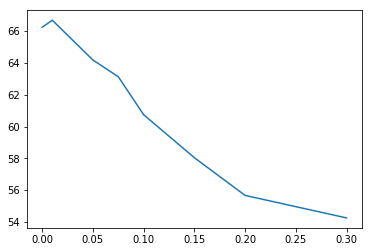

In [25]:
plt.plot(noises,noise_acc)
plt.show()

We see a smooth drop-off as more distortion is added to the fft bins, all the way up to .3, which represents nearly a third of the total normalized bins. It's impressive that the signal can be so degraded and the LDA model returns more than 50 percent accuracy. 

## 7. Future Work
Our work here is limited in several respects. Though we programmatically add distortion, this still doesn't represent the effects of real-world environmental variance likely to be faced by a production system. Future work will replace section 6 with recordings taken in different locations at different distances. Similarly, we will need to demonstrate the robustness of the model in differentiating oil cars from all other possible railcars. Limiting ourselves to intermodal cars is a significant limitation of this work. This was, however, a neccessary limitation given available data sizes. Many more recordings will need to be processed and accumulated. It remains to be determined whether or not a new model will be required for every railcar variety, or if our current approach will continue to suffice (oil cars vs. "other").

Finally, it's our ultimate goal for this system to operate within an embedded trackside system doing classifications in real-time. We imagine, moreover, such a system to be capable of updating its own models to better fit its current environment. Style transfer[7], a recent advance in image recognition/generation, suggests that it may indeed be possible to have a system capable of updating a pretrained model. The suitability of linear models for this task is promising. A next step will be prototyping a device and testing it in the same location that the data for this report was collected. 

## 8. Conclusions
We have demonstrated the possibility of using linear models for the classification of non-time series environmental audio. With accuracy rates of between 70 and 90 percent for an idealized case using data collected in one location our system is already suited for limited acoustic classification tasks. Moreover, using artificially degraded data we found that the model remains robust even as frequency-domain features are distorted as much as 30 percent.

### References 
[1] Omar et al, "Machine Learning Techniques for Anomaly Detection:
An Overview", https://pdfs.semanticscholar.org/0278/bbaf1db5df036f02393679d485260b1daeb7.pdf
[2] Aheard, "Growing oil train traffic is shrouded in secrecy", https://www.revealnews.org/article/growing-oil-train-traffic-is-shrouded-in-secrecy/
[3] "Urban Sound Classification", https://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/
[4] Shamir, "Classification of large acoustic datasets using machine learning and crowdsourcing: Application to whale calls", http://asa.scitation.org/doi/pdf/10.1121/1.4861348
[5] Yen, "AUTOMATIC FROG CALLS MONITORING SYSTEM: A MACHINE LEARNING APPROACH", DOI: 10.1142/S1469026801000184
[6] Acevedo, "Automated classification of bird and amphibian calls using machine learning: A comparison of methods", Automated classification of bird and amphibian calls using machine learning: A comparison of methods
[7] "Image Style Transfer Using Convolutional Neural Networks", http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
